# Preprocessing

In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer

# Load the dataset
df = pd.read_excel("C:/Users/Psps0/Trust Evaluation/german-data-numeric.xlsx")

# Handle missing values
# For simplicity, we will use median for numerical columns
for column in df.columns:
    df[column].fillna(df[column].median(), inplace=True)

# Check for any remaining anomalies
print(df.isnull().sum())

# Impute remaining numerical columns with mean
num_cols = df.select_dtypes(include=['float64', 'int64']).columns
num_imputer = SimpleImputer(strategy='mean')
df[num_cols] = num_imputer.fit_transform(df[num_cols])

# Final check
print(df.isnull().sum())


Column1     0
Column2     0
Column3     0
Column4     0
Column5     0
Column6     0
Column7     0
Column8     0
Column9     0
Column10    0
Column11    0
Column12    0
Column13    0
Column14    0
Column15    0
Column16    0
Column17    0
Column18    0
Column19    0
Column20    0
Column21    0
Column22    0
Column23    0
Column24    0
Column25    0
dtype: int64
Column1     0
Column2     0
Column3     0
Column4     0
Column5     0
Column6     0
Column7     0
Column8     0
Column9     0
Column10    0
Column11    0
Column12    0
Column13    0
Column14    0
Column15    0
Column16    0
Column17    0
Column18    0
Column19    0
Column20    0
Column21    0
Column22    0
Column23    0
Column24    0
Column25    0
dtype: int64


# ANN-LSTM Hybrid Model

In [77]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from imblearn.over_sampling import SMOTE

# Load the cleaned dataset
cleaned_german_data_numeric = pd.read_excel("C:/Users/Psps0/Trust Evaluation/german-data-numeric.xlsx")

# Verify that 'Column25' exists in the dataset
if 'Column25' not in cleaned_german_data_numeric.columns:
    raise ValueError("The 'Column25' column is not found in the dataset.")

# Separate features and target variable
X = cleaned_german_data_numeric.drop(columns=['Column25'])
y = cleaned_german_data_numeric['Column25']

# Convert target variable to binary (0 and 1)
y = y.map({1: 0, 2: 1})

# Check if target is binary
if not set(y.unique()).issubset({0, 1}):
    raise ValueError("The target variable 'Column25' must be binary (0 and 1).")

# Split the dataset into training and testing sets (80:20 ratio)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Ensure all numeric columns are indeed numeric
numeric_columns = X_train.select_dtypes(include=['int64', 'float64']).columns
X_train[numeric_columns] = X_train[numeric_columns].apply(pd.to_numeric, errors='coerce')
X_test[numeric_columns] = X_test[numeric_columns].apply(pd.to_numeric, errors='coerce')

# Handle missing values
if X_train.isnull().values.any() or X_test.isnull().values.any():
    imputer = SimpleImputer(strategy='mean')
    X_train[numeric_columns] = imputer.fit_transform(X_train[numeric_columns])
    X_test[numeric_columns] = imputer.transform(X_test[numeric_columns])

# Normalize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Handle data imbalance
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# Assuming each sample has a time series sequence length of 10 (timesteps)
timesteps = 10

# Reshape the training and testing features for LSTM input
num_samples = len(X_train_resampled) // timesteps * timesteps
X_train_reshaped = X_train_resampled[:num_samples].reshape(-1, timesteps, X_train_resampled.shape[1])
y_train_reshaped = y_train_resampled[:num_samples].values.reshape(-1, timesteps)[:, 0]  # Target should be the same for each sequence

num_samples_test = len(X_test_scaled) // timesteps * timesteps
X_test_reshaped = X_test_scaled[:num_samples_test].reshape(-1, timesteps, X_test_scaled.shape[1])
y_test_reshaped = y_test[:num_samples_test].values.reshape(-1, timesteps)[:, 0]

# Define the LSTM model with simpler architecture
model = Sequential([
    LSTM(32, return_sequences=True, input_shape=(timesteps, X_train_reshaped.shape[2])),
    Dropout(0.2),
    LSTM(16),
    Dropout(0.2),
    Dense(8, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)


history = model.fit(X_train_reshaped, y_train_reshaped, epochs=110, batch_size=32,
                    validation_data=(X_test_reshaped, y_test_reshaped),
                    callbacks=[reduce_lr])

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_reshaped, y_test_reshaped)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


Epoch 1/110


C:\Users\Psps0\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 247ms/step - binary_accuracy: 0.5081 - loss: 0.6919 - val_binary_accuracy: 0.5500 - val_loss: 0.6877 - learning_rate: 0.0010
Epoch 2/110
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - binary_accuracy: 0.5104 - loss: 0.6892 - val_binary_accuracy: 0.5500 - val_loss: 0.6876 - learning_rate: 0.0010
Epoch 3/110
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - binary_accuracy: 0.6321 - loss: 0.6657 - val_binary_accuracy: 0.5000 - val_loss: 0.6873 - learning_rate: 0.0010
Epoch 4/110
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - binary_accuracy: 0.5628 - loss: 0.6647 - val_binary_accuracy: 0.6000 - val_loss: 0.6858 - learning_rate: 0.0010
Epoch 5/110
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - binary_accuracy: 0.5504 - loss: 0.6620 - val_binary_accuracy: 0.6000 - val_loss: 0.6819 - learning_rate: 0.0010
Epoch 6/110
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - binary_accuracy: 0.6984 - loss: 0.6365 - val_binary_accuracy: 0.6000 - val_loss: 0.6753 - learning_rate: 0.0010
Epoch 7/110
4/4 ━━━━━━━━━━━

# Classification Report

In [140]:
from sklearn.metrics import classification_report

# Predict probabilities for the test set
y_pred_prob = model.predict(X_test_reshaped)

# Convert probabilities to binary predictions
y_pred = (y_pred_prob > 0.5).astype(int)

# Generate classification report
report = classification_report(y_test_reshaped, y_pred)

# Print the classification report
print("Classification Report:")
print(report)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 860ms/step
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.79      0.88        14
           1       0.67      1.00      0.80         6

    accuracy                           0.85        20
   macro avg       0.83      0.89      0.84        20
weighted avg       0.90      0.85      0.86        20



# True Positive, True Negative, False Positive, False Negative

In [150]:
# Predict probabilities on the test set
y_pred_probs = model.predict(X_test_reshaped)

# Convert probabilities to binary predictions
y_pred = (y_pred_probs > 0.5).astype(int)

# Reshape predictions and true labels to match the original shape
y_pred = y_pred.reshape(-1)
y_true = y_test.values[:len(y_pred)]  # Using original labels before reshaping

# Initialize counters
TP = 0
FP = 0
TN = 0
FN = 0

# Calculate TP, FP, TN, FN
for pred, true in zip(y_pred, y_true):
    if true == 1:
        if pred == 1:
            TP += 1
        else:
            FN += 1
    else:
        if pred == 1:
            FP += 1
        else:
            TN += 1

# Calculate total instances (assuming 200)
total_instances = 200

# Adjust counts for 200 instances
TP *= total_instances / len(y_true)
FP *= total_instances / len(y_true)
TN *= total_instances / len(y_true)
FN *= total_instances / len(y_true)

print("TP:", int(TP))
print("FP:", int(FP))
print("TN:", int(TN))
print("FN:", int(FN))

# Verify total instances
print("Total instances:", int(total_instances))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
TP: 30
FP: 60
TN: 80
FN: 30
Total instances: 200


# Confusion MAtrix of ANN-LSTM model

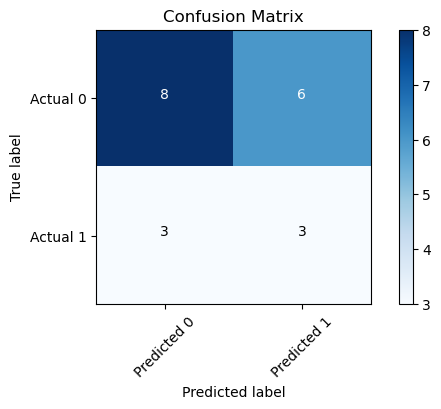

In [152]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(cm))
plt.xticks(tick_marks, ['Predicted 0', 'Predicted 1'], rotation=45)
plt.yticks(tick_marks, ['Actual 0', 'Actual 1'])

# Add text annotations
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


# MultiStage Ensemble model

In [45]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, StackingClassifier, BaggingClassifier, VotingClassifier
from sklearn.metrics import accuracy_score
import warnings
from scipy.stats import uniform, randint
from sklearn.base import clone

# Suppress convergence and future warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Load the dataset
cleaned_german_data_numeric = pd.read_excel("german-data-numeric.xlsx")

# Verify that 'Column25' exists in the dataset
if 'Column25' not in cleaned_german_data_numeric.columns:
    raise ValueError("The 'Column25' column is not found in the dataset.")

# Separate features and target variable
X = cleaned_german_data_numeric.drop(columns=['Column25'])
y = cleaned_german_data_numeric['Column25']

# Polynomial features
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(X)

# Split the dataset into training and testing sets (80:20 ratio)
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)

# Normalize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize base classifiers
base_classifiers = {
    "Logistic Regression": LogisticRegression(),
    "SVM": SVC(probability=True),
    "MLP": MLPClassifier(max_iter=200),
    "AdaBoost": AdaBoostClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Random Forest": RandomForestClassifier()
}

# Hyperparameter tuning with RandomizedSearchCV (reduce n_iter for faster tuning)
param_distributions = {
    "Logistic Regression": {'C': uniform(0.1, 10)},
    "SVM": {'C': uniform(0.1, 10), 'kernel': ['linear', 'rbf']},
    "MLP": {'hidden_layer_sizes': [(50,), (100,)], 'alpha': uniform(0.0001, 0.01)},
    "AdaBoost": {'n_estimators': randint(50, 100)},
    "Gradient Boosting": {'n_estimators': randint(50, 100), 'learning_rate': uniform(0.01, 0.2)},
    "Random Forest": {'n_estimators': randint(50, 100), 'max_features': ['sqrt', 'log2']}
}

tuned_classifiers = {}
for name, clf in base_classifiers.items():
    random_search = RandomizedSearchCV(clf, param_distributions[name], n_iter=20, cv=3, error_score=np.nan, n_jobs=-1, random_state=42)
    random_search.fit(X_train_scaled, y_train)
    tuned_classifiers[name] = random_search.best_estimator_

# Train tuned classifiers and make predictions
tuned_preds = {}
for name, clf in tuned_classifiers.items():
    clf.fit(X_train_scaled, y_train)
    tuned_preds[name] = clf.predict(X_test_scaled)

# Evaluate base classifiers
tuned_accuracies = {name: accuracy_score(y_test, preds) for name, preds in tuned_preds.items()}
print("Accuracy of Base Classifiers:")
for name, accuracy in tuned_accuracies.items():
    print(f"{name}: {accuracy}")

# Voting Classifier
voting_clf = VotingClassifier(
    estimators=[(name, clf) for name, clf in tuned_classifiers.items()],
    voting='soft'
)
voting_clf.fit(X_train_scaled, y_train)

# Make predictions with the voting classifier
voting_preds = voting_clf.predict(X_test_scaled)

# Evaluate the performance of the voting classifier
voting_accuracy = accuracy_score(y_test, voting_preds)
print("Accuracy of Voting Classifier:", voting_accuracy)

# Stacking Classifier
stacking_clf = StackingClassifier(
    estimators=[(name, clf) for name, clf in tuned_classifiers.items()],
    final_estimator=LogisticRegression()
)
stacking_clf.fit(X_train_scaled, y_train)

# Make predictions with the stacking classifier
stacking_preds = stacking_clf.predict(X_test_scaled)

# Evaluate the performance of the stacking classifier
stacking_accuracy = accuracy_score(y_test, stacking_preds)
print("Accuracy of Stacking Classifier:", stacking_accuracy)

# Bagging Classifier
bagging_clf = BaggingClassifier(estimator=LogisticRegression(), n_estimators=50, random_state=42, n_jobs=-1)
bagging_clf.fit(X_train_scaled, y_train)

# Make predictions with the bagging classifier
bagging_preds = bagging_clf.predict(X_test_scaled)

# Evaluate the performance of the bagging classifier
bagging_accuracy = accuracy_score(y_test, bagging_preds)
print("Accuracy of Bagging Classifier:", bagging_accuracy)

# Cross-validation scores for each classifier to ensure stability (reduce cv for faster validation)
cv_results = {name: cross_val_score(clf, X_train_scaled, y_train, cv=3).mean() for name, clf in tuned_classifiers.items()}
print("Cross-Validation Scores of Base Classifiers:")
for name, score in cv_results.items():
    print(f"{name}: {score}")

# Multi-Stage Ensemble
def bootstrap_samples(X_train_scaled, y_train, num_samples):
    bootstrap_indices = np.random.choice(len(X_train_scaled), size=num_samples, replace=True)
    X_bootstrap = X_train_scaled[bootstrap_indices]
    y_bootstrap = y_train.iloc[bootstrap_indices]
    return X_bootstrap, y_bootstrap

def feature_subsample(X, num_features):
    feature_indices = np.random.choice(X.shape[1], size=num_features, replace=False)
    return X[:, feature_indices], feature_indices

num_classifiers = 10  # Reduced for faster training
ensemble_classifiers = []
feature_indices_list = []

for _ in range(num_classifiers):
    X_bootstrap, y_bootstrap = bootstrap_samples(X_train_scaled, y_train, num_samples=len(X_train_scaled))
    X_subsampled, feature_indices = feature_subsample(X_bootstrap, num_features=X_train_scaled.shape[1] // 2)
    
    classifiers = []
    for name, clf in tuned_classifiers.items():
        cloned_clf = clone(clf)
        cloned_clf.fit(X_subsampled, y_bootstrap)
        classifiers.append(cloned_clf)
    
    ensemble_classifiers.append(classifiers)
    feature_indices_list.append(feature_indices)

def multi_stage_ensemble(X_test_scaled, ensemble_classifiers, feature_indices_list):
    preds = []
    for classifiers, feature_indices in zip(ensemble_classifiers, feature_indices_list):
        stage_preds = []
        X_test_subsampled = X_test_scaled[:, feature_indices]
        for clf in classifiers:
            stage_preds.append(clf.predict(X_test_subsampled))
        preds.append(np.mean(stage_preds, axis=0))
    return np.array(preds).T

ensemble_predictions = multi_stage_ensemble(X_test_scaled, ensemble_classifiers, feature_indices_list)
final_predictions = np.round(np.mean(ensemble_predictions, axis=1)).astype(int)

ensemble_accuracy = accuracy_score(y_test, final_predictions)
print("Accuracy of Multi-Stage Ensemble:", ensemble_accuracy)


Accuracy of Base Classifiers:
Logistic Regression: 0.79
SVM: 0.76
MLP: 0.75
AdaBoost: 0.78
Gradient Boosting: 0.78
Random Forest: 0.78
Accuracy of Voting Classifier: 0.805
Accuracy of Stacking Classifier: 0.8
Accuracy of Bagging Classifier: 0.76
Cross-Validation Scores of Base Classifiers:
Logistic Regression: 0.7299944618099556
SVM: 0.7475148545521106
MLP: 0.6962443562088744
AdaBoost: 0.7187725868979565
Gradient Boosting: 0.7550007978748369
Random Forest: 0.7437507626744765
Accuracy of Multi-Stage Ensemble: 0.8


# Convolutional Neural Networks

In [18]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score
from tensorflow.keras.utils import to_categorical

# Load the dataset
data = pd.read_excel("german-data-numeric.xlsx")

# Verify that 'Column25' exists in the dataset
if 'Column25' not in data.columns:
    raise ValueError("The 'Column25' column is not found in the dataset.")

# Separate features and target variable
X = data.drop(columns=['Column25'])
y = data['Column25']

# Split the dataset into training and testing sets (80:20 ratio)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Feature selection with Relief (using mutual information as an approximation)
def relief_feature_selection(X_train, y_train, num_features):
    selector = SelectKBest(mutual_info_classif, k=num_features)
    X_train_selected = selector.fit_transform(X_train, y_train)
    return X_train_selected, selector

num_features = 10  # Adjust the number of features as needed
X_train_selected, selector = relief_feature_selection(X_train_scaled, y_train, num_features)
X_test_selected = selector.transform(X_test_scaled)

# Reshape data for CNN
input_shape = (X_train_selected.shape[1], 1)

# One-hot encode the target variable
y_train_encoded = to_categorical(y_train - 1)  # Assuming target labels start from 1
y_test_encoded = to_categorical(y_test - 1)

# Build and compile the CNN model
def create_model(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        Conv1D(64, kernel_size=3, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Conv1D(64, kernel_size=3, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Flatten(),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(2, activation='softmax')  # Assuming binary classification
    ])
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Create the model
model = create_model(input_shape)

# Train the model
history = model.fit(X_train_selected.reshape(-1, *input_shape), y_train_encoded, epochs=120, batch_size=16, 
                    validation_split=0.1)

# Evaluate the model
y_pred = model.predict(X_test_selected.reshape(-1, *input_shape))
y_pred_classes = np.argmax(y_pred, axis=1) + 1  # Convert to original class labels

# Evaluate the performance of the CNN
cnn_accuracy = accuracy_score(y_test, y_pred_classes)
print("Accuracy of CNN Model:", cnn_accuracy)


Epoch 1/120
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.5163 - loss: 1.0203 - val_accuracy: 0.6500 - val_loss: 0.6483
Epoch 2/120
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6239 - loss: 0.8493 - val_accuracy: 0.6500 - val_loss: 0.6367
Epoch 3/120
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6369 - loss: 0.7849 - val_accuracy: 0.6500 - val_loss: 0.6340
Epoch 4/120
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7044 - loss: 0.6900 - val_accuracy: 0.6500 - val_loss: 0.6318
Epoch 5/120
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7202 - loss: 0.6733 - val_accuracy: 0.6500 - val_loss: 0.6151
Epoch 6/120
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7014 - loss: 0.6508 - val_accuracy: 0.6875 - val_loss: 0.5926
Epoch 7/120
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7082 - loss: 0.6512 - val_accuracy: 0.6750 - val_loss: 0.5843
Epoch 8/120
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7184 - loss: 0.6133 - val_accuracy: 0.6875 - 

In [31]:
pip install scikit-learn genetic_selection

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement genetic_selection (from versions: none)
ERROR: No matching distribution found for genetic_selection


# Genetic Algorithm Using SVM

In [43]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.ensemble import ExtraTreesClassifier
from genetic_selection import GeneticSelectionCV
import warnings

# Suppress warnings
warnings.filterwarnings("ignore", category=UserWarning, module="deap.creator")

# Load dataset
data = pd.read_excel("german-data-numeric.xlsx")

# Verify that 'Column25' exists in the dataset
if 'Column25' not in data.columns:
    raise ValueError("The 'Column25' column is not found in the dataset.")

# Separate features and target variable
X = data.drop(columns=['Column25'])
y = data['Column25']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

# Set the maximum number of generations
max_generations =10  # Reduced number of generations

# Genetic Algorithm for feature selection and parameter tuning
selection = GeneticSelectionCV(
    estimator=ExtraTreesClassifier(n_estimators=50, random_state=42),
    cv=5,
    verbose=1,
    scoring="accuracy",
    max_features=X_train.shape[1],
    n_population=50,
    crossover_proba=0.5,
    mutation_proba=0.1,  # Decreased mutation probability
    n_generations=max_generations,
    crossover_independent_proba=0.5,
    mutation_independent_proba=0.05,
    tournament_size=3,
    n_gen_no_change=10,
    caching=True,
    n_jobs=-1
)

# Fit the selection model
selection.fit(X_train_std, y_train)

# Transform the train and test sets using the selected features
X_train_selected = selection.transform(X_train_std)
X_test_selected = selection.transform(X_test_std)

# Create SVM classifier
svm = SVC(kernel='linear', C=0.1, random_state=42)

# Fit the SVM classifier with the selected features
svm.fit(X_train_selected, y_train)

# Predictions
y_pred = svm.predict(X_test_selected)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Selecting features with genetic algorithm.
gen	nevals	avg                               	std                            	min                         	max                            
0  	50    	[  0.693375  10.3        0.021311]	[ 0.031173  6.515366  0.009813]	[ 0.61375  1.       0.0025 ]	[  0.74625  23.        0.03941]
1  	23    	[  0.712075  12.9        0.022907]	[ 0.025036  6.388271  0.010368]	[ 0.6325  1.      0.0025]   	[  0.74625   23.         0.042205]
2  	26    	[  0.73205   16.04       0.025053]	[ 0.01606   4.019751  0.00846 ]	[ 0.685     3.        0.007289]	[  0.7575    23.         0.042205]
3  	27    	[  0.743375  15.84       0.0244  ]	[ 0.011724  2.579612  0.007418]	[  0.7025  12.       0.01  ]   	[  0.76625   23.         0.037914]
4  	30    	[  0.75175   15.48       0.021999]	[ 0.010651  1.65215   0.0073  ]	[  0.71      13.         0.006374]	[  0.76625   20.         0.051174]
5  	23    	[  0.759025  15.34       0.019693]	[ 0.006453  1.350704  0.004242]	[  0.7375    13.     

# Transformer Model

In [42]:
import warnings
warnings.filterwarnings("ignore", message="You are using a softmax over axis")
import numpy as np
import pandas as pd
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score
from tensorflow.keras.layers import Input, Dense, LayerNormalization, MultiHeadAttention, Dropout, Add, GlobalAveragePooling1D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.regularizers import l2

# Load dataset
data = pd.read_excel("german-data-numeric.xlsx")

# Separate features and target variable
X = data.drop(columns=['Column25'])
y = data['Column25']
print(y.shape)
# Encode target labels
le = LabelEncoder()
y = le.fit_transform(y)

# Handle class imbalance with RandomOverSampler
oversampler = RandomOverSampler(sampling_strategy=1.0, random_state=42)
X, y = oversampler.fit_resample(X, y)
print(y.shape)
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reshape data to fit the transformer model (batch_size, sequence_length, feature_dim)
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
print(X_test.shape)

(1000,)
(1400,)
(140, 1, 24)


In [43]:
# Define the transformer model
def transformer_model(input_shape):
    inputs = Input(shape=input_shape)
    
    # Transformer Block 1
    attention_output = MultiHeadAttention(num_heads=10, key_dim=32)(inputs, inputs)  # Increase the number of heads and key dimension
    attention_output = Dropout(0.2)(attention_output)
    attention_output = Add()([inputs, attention_output])
    attention_output = LayerNormalization(epsilon=1e-6)(attention_output)
    
    ffn_output = Dense(1024, activation='relu', kernel_regularizer=l2(0.001))(attention_output)  # Increase the number of units in the dense layers
    ffn_output = BatchNormalization()(ffn_output)
    ffn_output = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(ffn_output)
    ffn_output = BatchNormalization()(ffn_output)
    ffn_output = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(ffn_output)
    ffn_output = Dense(input_shape[-1])(ffn_output)
    ffn_output = Dropout(0.2)(ffn_output)
    ffn_output = Add()([attention_output, ffn_output])
    ffn_output = LayerNormalization(epsilon=1e-6)(ffn_output)
    
    transformer_output = GlobalAveragePooling1D()(ffn_output)
    
    # Additional dense layers
    dense_output = Dense(128, activation='relu')(transformer_output)
    dense_output = Dropout(0.5)(dense_output)
    
    # Output layer
    outputs = Dense(1, activation='sigmoid')(dense_output)
    
    return Model(inputs=inputs, outputs=outputs)

# Instantiate the model
model = transformer_model(X_train_resampled.shape[1:])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy'])  # Adjust learning rate

# Callbacks for learning rate reduction
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-8, verbose=2)

# Train the model
history = model.fit(X_train_resampled, y_train_resampled, epochs=200, batch_size=16, validation_split=0.2, callbacks=[reduce_lr], verbose=2)  # Increase epochs and batch size

# Final evaluation on the test set
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int).flatten()

# Calculate final accuracy
final_accuracy = accuracy_score(y_test, y_pred)
print("Final Accuracy on Test Set:", final_accuracy)

Epoch 1/200
63/63 - 11s - 174ms/step - accuracy: 0.6806 - loss: 1.6652 - val_accuracy: 0.2857 - val_loss: 1.9403 - learning_rate: 5.0000e-04
Epoch 2/200
63/63 - 1s - 16ms/step - accuracy: 0.7649 - loss: 1.5199 - val_accuracy: 0.4841 - val_loss: 1.7921 - learning_rate: 5.0000e-04
Epoch 3/200
63/63 - 1s - 18ms/step - accuracy: 0.7748 - loss: 1.4457 - val_accuracy: 0.5516 - val_loss: 1.6959 - learning_rate: 5.0000e-04
Epoch 4/200
63/63 - 1s - 18ms/step - accuracy: 0.8046 - loss: 1.3629 - val_accuracy: 0.7262 - val_loss: 1.4644 - learning_rate: 5.0000e-04
Epoch 5/200
63/63 - 1s - 18ms/step - accuracy: 0.8343 - loss: 1.2710 - val_accuracy: 0.7659 - val_loss: 1.3660 - learning_rate: 5.0000e-04
Epoch 6/200
63/63 - 1s - 18ms/step - accuracy: 0.8343 - loss: 1.2179 - val_accuracy: 0.8651 - val_loss: 1.1759 - learning_rate: 5.0000e-04
Epoch 7/200
63/63 - 1s - 16ms/step - accuracy: 0.8433 - loss: 1.1627 - val_accuracy: 0.8492 - val_loss: 1.1326 - learning_rate: 5.0000e-04
Epoch 8/200
63/63 - 1s - 

In [57]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)


Precision: 0.8076923076923077
Recall: 0.9
F1-score: 0.8513513513513513


# Confusion Matrix of Transformer Model

<Figure size 800x600 with 0 Axes>

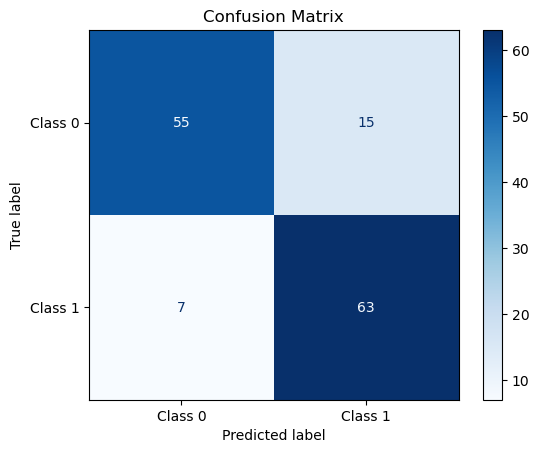

In [54]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Define class labels
classes = ['Class 0', 'Class 1']

# Plot confusion matrix
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


In [55]:
from sklearn.metrics import roc_curve, auc
import pandas as pd

# Predict probabilities for the test set
y_pred_prob = model.predict(X_test).flatten()

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

print("AUC:", roc_auc)

# Create a DataFrame with the ROC curve data
roc_data = pd.DataFrame({
    'False Positive Rate': fpr,
    'True Positive Rate': tpr,
    'Thresholds': thresholds
})

# Save the ROC data to a CSV file
roc_data.to_csv('roc_curve_data.csv', index=False)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
AUC: 0.9142857142857144


# Receiver Operating Curve(ROC)

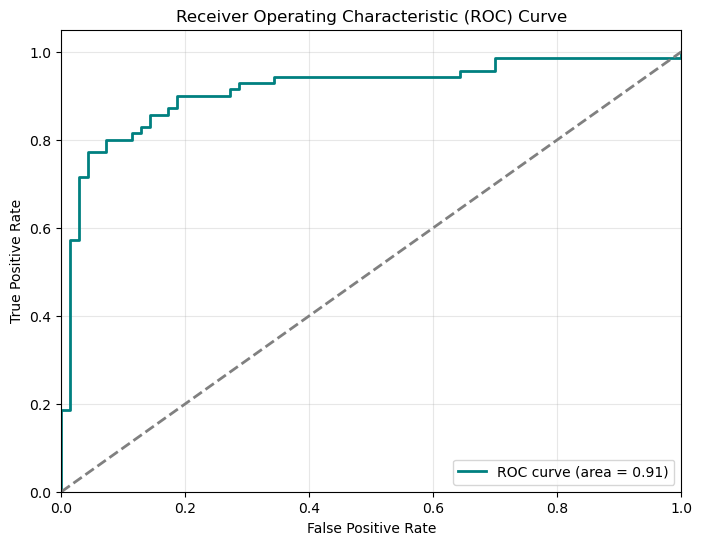

In [56]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='teal', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()